# Kickstarter - Meme Master Memory

by Martina Gottschalk, Petra Pinger and Ole Hansen 

## Business case: 
Mr. Brain invented a Meme Master Memory (a memory game with videos/gifs) and needs money for the implementation. He wants to do the project in 4 weeks, wants to get 100,000USD and wants to launch the campaign in summertime in the category photography.
Under these circumstances, will the project be successful? Furthermore we want to recommend Mr. Brain different improvements to increase his chance for success. In addition we also want to predict his potential pledged amount. 

## Approach:

* Business Understanding:
    * Kickstarter is a Crowdfunding website that enables entrepreneurs to fund money for their business ideas.
    * With regard to our business case we are looking for the features that might be relavant for the success of the project, especially with regard to the characteristics of our stakeholders project (e.g., product category, season) 
    * Evaluation metrics: It is in our stakeholders interest that we are confident in our prediction of success and that we avoid the case that our stakeholder puts a lot of effort in a project that is likely to fail. In other words we want to avoid a false positive prediction and that is why we choose precision as our main evlaution metric.
<br/>
<br/>
* Data Collection 
    * For our data analysis and modeling we use a well known kaggle dataset. Our data science bootcamp teachers gave us the dataset but similar datasets can be found online.
    * An overview of all the columns in the dataset can be found below.
<br/>
<br/>
* EDA:
    * see Jupyter Notebook "Kickstarter_EDA" for an EDA 
<br/>
<br/>
* Feature Engineering / Data Cleaning:
    * see Jupyter Notebook "Kickstarter" for data preparation, cleaning and feature engineering
<br/> 
<br/>
* Predictive Modeling
    * We will use a simple logistic regression, SVM and random forest to predict the success of the project. The classification models can be found in the Jupyter Notebook "Kickstarter"
    * For the prediciton of the total amount that the stakeholder could pledge we use a polynomial regression, random forest and Adaboost. This is still work in progess. First models do not show a reasonable fit and further analyses might be needed.
<br/>
<br/>
* Stakeholder Presentation  

# Data cleaning

In this notebook we will clean our Dataframe 'Kickstarter_merged.csv'. That means we will create new columns which we think are important as well as we will drop columns with unimportance.

#### Overview new columns
    * column 'blurbs' will be replaced with -> 'blurb_len_w'
    * column 'slug' will be trplaced with -> 'slug_len_w', 
    * column 'category' will be replaced with -> 'parent_name'
    * column 'launched_at' will be replaced with -> 'launched_month'
    * new column duration of the crowdfunding
    * new column preparation time (from created_at until launched_at
    * column 'state_changed_at' will be replaced with -> 'state_changed_year', 'state_changed_month, 
    * new column pledged/backer
    * column 'goal' will be converted in USD

#### Overview dropped columns
    * converted_pledged_amount
    * creator
    * currency 
    * currency_symbol
    * currency_trailing_code
    * current_curency
    * disable_communication
    * friends
    * fx_rate
    * id after using it for other transformations
    * is_backing
    * is_starrable
    * is_starred
    * location
    * name 
    * permissions
    * photo
    * pledged
    * profile 
    * slug
    * source_url
    * spotlight
    * state_changed_at 
    * static_usd_rate 
    * urls
    * usd_type
   
    
    
#### Overview dropped rows
    * 8 rows with missing values in column 'blurbs'
    * drop the duplicates
    * drop rows with values 'suspended' and 'live' in column 'state'


In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import time
import datetime as dt
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression


import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
import itertools
import warnings 
warnings.filterwarnings('ignore')

Read in file.

In [2]:
df = pd.read_csv('data/Kickstarter_merged.csv', index_col=0)

## Create new columns
    
Let´s start with creating new columns:

### Length of Blurb in words:
The blurb is the description of a kickstarter project. We assume that the length of the project description is an indicator of how well a project is described and presented and that a good presentation is relevant for success.

In [3]:
def string_len_w(string):
    '''Return length of string (number of word, seperated by Space).'''
    string_str = str(string)
    string_list = string_str.split()
    string_len = len(string_list)
    return string_len

In [4]:
def add_blurb_len_w (df):
    '''Adding column that contains the length of the Blurb (words) and returns the updated Dataframe'''
    df['blurb_len_w'] = df.apply(lambda x: string_len_w(x['blurb']), axis=1)
    return df

In [5]:
df = add_blurb_len_w(df)

### Length of Slug in words:
The slug is the addition in the URL and is equal to the project name. We think that a longer name is a better description of the project and more relevant keywords are easier to be found by web crawler (relevant for Search Engine Optimization). Therefore we think that longer slugs are associated with success.

In [6]:
def string_len_slug_w(string):
    '''Returns length of string (number of words, seperated by "-").'''
    string_str = str(string)
    string_list = string_str.split("-")
    string_len = len(string_list)
    return string_len

In [7]:
def add_slug_len_w (df):
    '''Adding column that contains the length of the Slug (words) and returns the updated Dataframe'''
    df['slug_len_w'] = df.apply(lambda x: string_len_slug_w(x['slug']), axis=1)
    return df

In [8]:
df = add_slug_len_w(df)

 ### Category aka parent_name
 In this section we extract the category name out of information saved as a json type. We think certain categories (e.g. games) are more successfull than others (e.g. music).

In [9]:
def add_parent_id(df):
    '''Extracts Parent ID out of the Category json and adds the Column to Dataframe. Returns updated Dataframe'''
    df['category_parent_id'] = pd.DataFrame([json.loads(df["category"][i]).get("parent_id") for i in range(df.shape[0])])
    return df

In [10]:
def add_category_id(df):
    '''Extracts category ID out of the Category json and adds the Column to Dataframe. Returns updated Dataframe'''
    df['category_id'] = pd.DataFrame([json.loads(df["category"][i]).get("id") for i in range(df.shape[0])])
    return df

In [11]:
def add_category_name(df):
    '''Extracts category name out of the Category json and adds the Column to Dataframe. Returns updated Dataframe'''
    df['category_name'] = pd.DataFrame([json.loads(df["category"][i]).get("name") for i in range(df.shape[0])])
    return df

In [12]:
def fill_na(df, column_name):
    '''Fill Missings with 0 as type integer. Returns updated dataframe. eg, for parent ID and pledged per backer'''
    df[column_name] = df[column_name].fillna(0).astype("int")
    return df

In [13]:
# Making a list based on entry in one category and if missing adds entry of another Column
def helper_list():
    '''Making a list based on entry in one category and if missing adds entry of another Column'''
    empty = []
    for i in range(df.shape[0]):
        if df["category_parent_id"][i] != 0:
            empty.append(df["category_parent_id"][i])
        else:
            empty.append(df["category_id"][i])
    return empty

In [14]:
# adds helper list as column to dataframe 
def add_list_as_column(df, column_name, list_name):
    '''Adds helper list as column to dataframe and retruns updated dataframe'''
    df[column_name] = pd.DataFrame(list_name)
    return df

In [15]:
def add_parent_name(df, column_name1, column_name2, dictionary):
    '''based on key value in a column, column with value is added as a column and updated dataframe is returned. 
    Example:
        parents_dict = {1: "Art", 3: "Comics", 6: "Dance", 7: "Design", 9: "Fashion", 10: "Food",
                11: "Film & Video", 12: "Games", 13: "Journalism", 14: "Music", 15: "Photography", 16: "Technology",
               17: "Theater", 18: "Publishing", 26: "Crafts"}
            df["parent_name"] = df["filled_parent"].apply(lambda x: parents_dict.get(x))'''
    df[column_name1] = df[column_name2].apply(lambda x: dictionary.get(x))
    return df

In [16]:
df = add_parent_id(df)
df = add_category_id(df)
df = add_category_name(df)
df = fill_na(df, 'category_parent_id')

In [17]:
empty = []
for i in range(df.shape[0]):
    if df["category_parent_id"][i] != 0:
        empty.append(df["category_parent_id"][i])
    else:
        empty.append(df["category_id"][i])

In [18]:
df = add_list_as_column(df, "filled_parent", empty)

In [19]:
df = add_parent_name(df, "parent_name", "filled_parent", {1: "Art", 3: "Comics", 6: "Dance", 7: "Design", 9: "Fashion", 10: "Food",
                11: "Film & Video", 12: "Games", 13: "Journalism", 14: "Music", 15: "Photography", 16: "Technology",
               17: "Theater", 18: "Publishing", 26: "Crafts"})

In [20]:
df["parent_name"]

0              Fashion
1                Games
2                Music
3                Games
4           Publishing
              ...     
209217           Games
209218           Music
209219      Technology
209220    Film & Video
209221      Journalism
Name: parent_name, Length: 209222, dtype: object

### Month launched
In the dataset we have a timestamp for the moment the project was created, launched and ended (deadline). We think that the month/season a project is launched influences its success.

In [21]:
#funtion to extract the month out of the number
def extract_month(number):
    '''Extracts the month out of the number and returns the month'''
    gmtime = time.gmtime(number)
    return gmtime[1]

In [22]:
# Adding column with month the project was launched
def adding_month_launched(df):  
    '''Adding column with month the project was launched and returns the updated dataframe'''
    df["launched_month"] = df.apply(lambda x: extract_month(x["launched_at"]), axis=1)
    return df

In [23]:
df = adding_month_launched(df)

### Duration
The duration is the time period between the moment it was launched and the deadline. We created a feature by substracting the corresponding timestamps. We assume that the duration of a project influences its success.

In [24]:
def duration(deadline, launched_at):
    '''Calculating difference between two timepoints and returns it in days'''
    duration = deadline - launched_at
    duration_complete = dt.timedelta(seconds=duration)
    return duration_complete.days

In [25]:
# Adding column with duration in days
def adding_duration(df):
    '''Adding column with duration in days and returns updated dataframe'''
    df["duration_days"] = df.apply(lambda x: duration(x["deadline"], x["launched_at"]), axis=1)
    return df

In [26]:
df = adding_duration(df)

### Preparation 
Similar to duration, the preparation is the period between the creation and the moment the poject is launched. Again we assume that a longer preparation might be relevant for success.

In [27]:
def adding_preparation(df):
    '''Adding column with preparation in days and returns updated dataframe'''
    df["preparation"] = df.apply(lambda x: duration(x["launched_at"], x["created_at"]), axis=1)
    return df

In [28]:
df = adding_preparation(df)

### pledged/backer as "Reward Amount"
The project owner can set a reward for a certain amount that is pledged. As an indicator of this amount we used the average amount pledged per backer. The reward size might influence how fast the goal is reached and consequently for the success of a project. 

In [29]:
def adding_pledged_per_backer(df):
    '''Adding column that is the averaged amount pledged per backer, returns updated dataframe'''
    df['pledged_per_backer'] = (df['usd_pledged'] / df['backers_count']).round(2)
    return df

In [30]:
df = adding_pledged_per_backer(df)

There are cases in our dataset with no backers. Because we cannot devide by zeros we have to convert the resulted missing values to 0.

In [31]:
df.pledged_per_backer = df.pledged_per_backer.fillna(0).astype("int")

### Coverting Goal to USD
To garantee comparability of different currencies we convert the goal to USD. The amount of the goal is directly related to the success. The lower the goal is set, the more likely it is to be reached.

In [32]:
def usd_convert_goal(df, column_name, exchange_rate): 
    '''Converts a Column based on given exchange rate, rounds it to two decimal spaces  
    and returns updated dataframe, e.g. 
    df['goal'] = (df['goal'] * df['static_usd_rate']).round(2)'''
    df[column_name] = (df[column_name] * df[exchange_rate]).round(2)
    return df

In [33]:
df = usd_convert_goal(df, 'goal', 'static_usd_rate')

In [34]:
df['goal']

0         28000.00
1          1000.00
2         15000.00
3         12160.66
4          2800.00
            ...   
209217     1500.00
209218     5466.50
209219     2500.00
209220     5500.00
209221     1000.00
Name: goal, Length: 209222, dtype: float64

## Drop rows
We drop few rows that have missing values in the column "blurbs" and duplicates. We checked for differences in the duplicated rows. The only column that differs, is the type of usd_type (domestic vs. international Dollars). Out of the duplicates we kept the latest because we assume that this would be the latest version.

Futhermore, we drop one project that has a goal of 0 Dollar because this is not realistic.

Because we want to predict the success of a project we decided to focus on the projects that have a certain state of success or failure. We therefore drop rows with the state "live", "canceled", "suspended".

In [35]:
def drop_rows_missings(df, column_name):
    '''Drop rows with missing values in column, eg. Blurb. Retruns dataframe.'''
    df.dropna(subset = [column_name], inplace=True)
    return df

In [36]:
def drop_duplicates(df, column_name):
    '''Creating dataframe and dropping all duplicates, based on a column_name (eg, ID) 
    and keep the last ("newest") duplicate'''
    df = df.drop_duplicates(subset=['id'], keep='last')
    return df

In [37]:
# drop rows with values certain values in a dataframe and returns updated dataframe, eg 'suspended' and 'live' in column 'state'
def drop_rows_value (df, column_name, value):
    '''drop rows with values certain values in a dataframe and returns updated dataframe'''
    df = df.drop(df[df[column_name] == value ].index)
    return df

In [38]:
# drop 8 rows with missing values in column 'blurbs'
df = drop_rows_missings(df, 'blurb')

In [39]:
# creating dataframe and dropping all duplicates and keep the last ("newest") duplicate 
df = drop_duplicates(df, 'id')

In [40]:
df = drop_rows_value(df, 'state', 'suspended')

In [41]:
df = drop_rows_value(df, 'state', 'live')

In [42]:
df = drop_rows_value(df, 'state', 'canceled')

In [43]:
df = drop_rows_value(df, 'goal', 0)

## Drop Columns

Now, we drop all columns that we assume not to be relevant. 

In [44]:
def drop_columns(df, list_columns):
    '''Drops columns in the list and returns updated datadrame'''
    df.drop(list_columns, axis=1, inplace=True)
    return df

In [45]:
df.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'creator', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'location',
       'name', 'permissions', 'photo', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_pledged', 'usd_type', 'blurb_len_w',
       'slug_len_w', 'category_parent_id', 'category_id', 'category_name',
       'filled_parent', 'parent_name', 'launched_month', 'duration_days',
       'preparation', 'pledged_per_backer'],
      dtype='object')

In [46]:
df = drop_columns(df, ['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'creator', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'location',
       'name', 'permissions', 'photo', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_type', 'category_parent_id', 'category_id', 'category_name',
       'filled_parent', 'staff_pick'])

## Drop Rows and only keep relevant categories

Our stakeholder's project would only fit into one of the following categories: "Games", "Art", "Photography", "Film & Video", "Design", "Technology". Therefore we will drop all rows with other categories.

In [47]:
categories = ["Games", "Art", "Photography", "Film & Video", "Design", "Technology"]
df = df[df.parent_name.isin(categories)]

## Get Dummies
For modeling we convert the categories into dummies. Because we want to include the season in our model we converted the month_launched into 4 seasons and make dummies out of that new column. The old column we drop.

In [48]:
# convert the categorical variable parent_name into dummy/indicator variables
df_dum2 = pd.get_dummies(df.parent_name, prefix='parent_name')
df = df.drop(['parent_name'], axis=1)
df = pd.concat([df, df_dum2], axis=1)

In [49]:
# making a categorical variable for launched_month q1, q2, q3, q4 
df.loc[df['launched_month'] <  4, 'time_yr'] = 'q1'
df.loc[(df['launched_month'] >=  4) & (df['launched_month'] <  7), 'time_yr'] = 'q2'
df.loc[(df['launched_month'] >=  7) & (df['launched_month'] <  10), 'time_yr'] = 'q3'
df.loc[df['launched_month'] >  9, 'time_yr'] = 'q4'

In [50]:
df_dum3 = pd.get_dummies(df.time_yr, prefix='time_yr')
df = df.drop(['time_yr'], axis=1)
df = df.drop(['launched_month'], axis=1)
df = pd.concat([df, df_dum3], axis=1)

## Reset index

In [51]:
df = df.reset_index()

In [52]:
df = df.drop(['index'], axis = 1)

In [53]:
df.head()

,goal,state,usd_pledged,blurb_len_w,slug_len_w,duration_days,preparation,pledged_per_backer,parent_name_Art,parent_name_Design,parent_name_Film & Video,parent_name_Games,parent_name_Photography,parent_name_Technology,time_yr_q1,time_yr_q2,time_yr_q3,time_yr_q4
0,1000.00,successful,1950.000000,22,4,30,8,41,0,0,0,1,0,0,0,0,1,0
1,12160.66,failed,165.384934,23,7,59,5,55,0,0,0,1,0,0,1,0,0,0
2,54737.83,failed,5.473783,3,2,20,3,5,1,0,0,0,0,0,0,0,1,0
3,2602.33,successful,2861.258251,19,3,21,2,38,0,0,0,0,1,0,0,0,0,1
4,5000.00,successful,5466.000000,25,7,29,0,84,1,0,0,0,0,0,1,0,0,0


# Classification

As a next step, we want to predict our stakeholder's success chances. To do so, we train a classification model based on our data. Because we want to use the current dataset for classification and regression, we rename/duplicate the dataframe at this point.

In [54]:
df_c = df.copy()

Our target value for the prediction is the column "state". We convert this column into binary integers. 

In [55]:
df_c['state'] = np.where(df_c['state'] == 'successful', 1, 0)

For classification we don't need usd_pledged, because we would not know this in advance. 'usd_pledged' will be our target variable in the regression model. 

In [56]:
df_c = drop_columns(df_c, ['usd_pledged'])

## Training the Model
### Train-Test-Split
Before we fit our model we have to split our data into test and train data. 

In [57]:
y = df_c.state
X = df_c.drop('state', axis=1)

In [58]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [59]:
# we have to define which columns we want to scale.
col_scale = ['goal', 'blurb_len_w', 'slug_len_w', 'duration_days', 'preparation', 'pledged_per_backer']

### Data standardization
To bring all our numeric features on the same scale we standardize them.

In [60]:
# we have to define which columns we want to scale.
col_scale = ['goal', 'blurb_len_w', 'slug_len_w', 'duration_days', 'preparation', 'pledged_per_backer']

In [61]:
# Scaling with standard scaler
scaler = StandardScaler()
X_train_scaled_st = scaler.fit_transform(X_train[col_scale])
X_test_scaled_st = scaler.transform(X_test[col_scale])

In [62]:
# Concatenating scaled and dummy columns 
X_train_preprocessed_st = np.concatenate([X_train_scaled_st, X_train.drop(col_scale, axis=1)], axis=1)
X_test_preprocessed_st = np.concatenate([X_test_scaled_st, X_test.drop(col_scale, axis=1)], axis=1)

In [63]:
X_train

,goal,blurb_len_w,slug_len_w,duration_days,preparation,pledged_per_backer,parent_name_Art,parent_name_Design,parent_name_Film & Video,parent_name_Games,parent_name_Photography,parent_name_Technology,time_yr_q1,time_yr_q2,time_yr_q3,time_yr_q4
9821,4185.50,20,7,30,0,52,0,0,0,0,0,1,0,0,0,1
28127,50000.00,22,9,30,160,640,0,0,0,0,0,1,1,0,0,0
38231,500.00,20,3,30,40,68,1,0,0,0,0,0,0,1,0,0
61633,2500.00,16,2,27,10,28,0,0,0,0,1,0,1,0,0,0
35844,16000.00,20,6,25,4,343,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14641,50000.00,21,9,31,192,130,0,0,0,0,0,1,1,0,0,0
43152,5309.27,21,5,29,20,0,0,0,0,0,1,0,1,0,0,0
31522,1100.00,16,7,60,9,5,1,0,0,0,0,0,0,1,0,0
18438,10000.00,22,8,30,3,60,0,1,0,0,0,0,1,0,0,0


## Logistic Regression
We start with a simple logistic regression. We fit the model and print the confusion matrix and the classification report.

In [64]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.73      0.61      0.66      7732
           1       0.70      0.80      0.74      8676

    accuracy                           0.71     16408
   macro avg       0.71      0.70      0.70     16408
weighted avg       0.71      0.71      0.71     16408

Confusion matrix, without normalization
[[4723 3009]
 [1767 6909]]


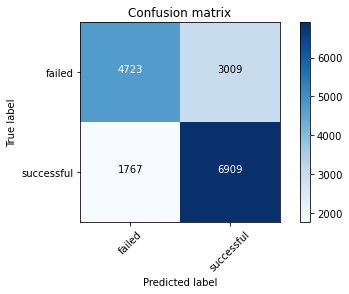

In [65]:
# fit model
lr = LogisticRegression()
lr.fit(X_train_preprocessed_st, y_train)
y_pred = lr.predict(X_test_preprocessed_st)
cnf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['failed','successful'],normalize= False,  title='Confusion matrix')

### Conclusion
* For the evaluation of the model we look at the precision of the model. In this case we have a precision of 70 % (6909 true positive/(6909 true positive + 3009 false positive)
* That means that 70% of all the projects that are predicted to be successful, in fact have a successful out
* In the following we will use an ensemble algorithm to check if we can improve the precision of the model

## Random Forrest

In [66]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=42, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

In [67]:
# Fit on training data
model.fit(X_train_preprocessed_st, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished


RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=42,
                       verbose=1)

In [68]:
y_pred = model.predict(X_test_preprocessed_st)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           0       0.85      0.73      0.79      7732
           1       0.79      0.89      0.83      8676

    accuracy                           0.81     16408
   macro avg       0.82      0.81      0.81     16408
weighted avg       0.82      0.81      0.81     16408

Confusion matrix, without normalization
[[5624 2108]
 [ 963 7713]]


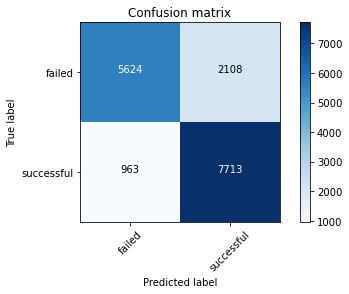

In [69]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['failed','successful'],normalize= False,  title='Confusion matrix')

* Compared to the logistic regression model, the precision improved to 79%.
* Next we try to improve the random forest model by using a gridsearch tune the hyperparameters

### Hyperparameter Tuning / Gridsearch

In [70]:
# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}
# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 42)
# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 5, random_state=42)
# Fit 
rs.fit(X_train_preprocessed_st, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:  1.0min remaining:   22.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                     

In [71]:
rs.best_params_

{'n_estimators': 196,
 'min_samples_split': 10,
 'max_leaf_nodes': 49,
 'max_features': 0.7,
 'max_depth': 17,
 'bootstrap': True}

In [72]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=196, 
                               random_state=42, 
                               min_samples_split=10,
                               max_leaf_nodes=49,
                               max_features=0.7,
                               max_depth=17,
                               bootstrap=True,
                               n_jobs=-1, verbose = 1)

In [73]:
# Fit on training data
model.fit(X_train_preprocessed_st, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 196 out of 196 | elapsed:    4.8s finished


RandomForestClassifier(max_depth=17, max_features=0.7, max_leaf_nodes=49,
                       min_samples_split=10, n_estimators=196, n_jobs=-1,
                       random_state=42, verbose=1)

In [74]:
y_pred = model.predict(X_test_preprocessed_st)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 196 out of 196 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           0       0.88      0.69      0.77      7732
           1       0.77      0.92      0.84      8676

    accuracy                           0.81     16408
   macro avg       0.83      0.80      0.80     16408
weighted avg       0.82      0.81      0.81     16408

Confusion matrix, without normalization
[[5324 2408]
 [ 710 7966]]


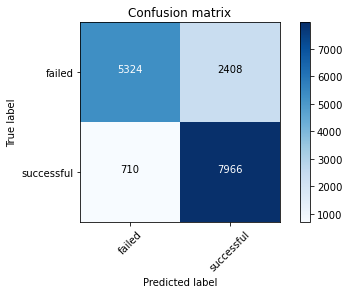

In [75]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
np.set_printoptions(precision=2)
print (classification_report(y_test, y_pred))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['failed','successful'],normalize= False,  title='Confusion matrix')

### Conclusion
* When we used the best hyperparameters found in our gridsearch our model shows a higher recall (92%). That means that out of 100 successful projects 92 are correctly classified.
* But: the precision of the model decreased to 77%. For us this is the main focus because we do not want avoid that our clients project is classified to be successful but fails in the end. Therefore we will use our initial parameters for the prediciton. 

# Regression
* As an additional service for our stakeholder we want to predict how much money he can pledge if his project is successful
* To do so we will use a regression model
* But first, we will have to do some modification to our dataset. We will drop all unsuccessful projects because projects only receive money in the case of success (pledged amount is higher than the goal).

In [76]:
# creaste new dataframe for regression
df_r = df.copy()

Our target value for the prediction is the column "usd_pledged". 

In [77]:
# drop unsuccessful projects
df_r = df_r.drop(df_r[df_r['state'] == "failed" ].index)

For regression we don't need the column "state" anymore. So we drop the column.

In [78]:
df_r = drop_columns(df_r, ['state'])

## Training the Model
### Train-Test-Split
Before we fit our model we have to split our data into test and train data.

In [79]:
y = df_r['usd_pledged']
X = df_r.drop('usd_pledged', axis=1)

In [80]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Remove outlier
Because our client does not want to pledge a very small amount and also no very high amount, we will remove the extreme "outlier"

In [81]:
# we concatenate the X_train and y_train sets in order to remove the rows from both sets.
new = pd.concat([X_train, y_train], axis=1)

# define the borders for extreme values
lower = new['usd_pledged'].quantile(0.025)
upper = new['usd_pledged'].quantile(0.975)

# remove extreme values
new_2 = new[(new['usd_pledged'] < upper) & (new['usd_pledged'] > lower)]

# now we split again into y_train and X_train
y_train = new_2['usd_pledged']
X_train = new_2.drop('usd_pledged', axis=1)

### Scaling

In [82]:
# Scaling with standard scaler
scaler = StandardScaler()
X_train_scaled_st = scaler.fit_transform(X_train[col_scale])
X_test_scaled_st = scaler.transform(X_test[col_scale])

In [83]:
# Concatenating scaled and dummy columns 
X_train_preprocessed_st = np.concatenate([X_train_scaled_st, X_train.drop(col_scale, axis=1)], axis=1)
X_test_preprocessed_st = np.concatenate([X_test_scaled_st, X_test.drop(col_scale, axis=1)], axis=1)

## Polynomial Regression
We start with a simple polynomial regression with second degree which is a linear regression. We fit the model and print the root mean squared error, mean percentage error, $R^2$.

In [84]:
# Compute mean absolute percentage error
def mean_absolute_percentage_error(y_train, y_pred): 
    y_train, y_pred = np.array(y_train), np.array(y_pred)
    return np.mean(np.abs((y_train - y_pred) / y_train)) * 100

In [85]:
poly_reg = PolynomialFeatures(degree=1)
X_poly = poly_reg.fit_transform(X_train_preprocessed_st)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y_train)

X_poly_test = poly_reg.fit_transform(X_test_preprocessed_st)
X_poly_test.shape

(8676, 17)

In [86]:
y_pred = pol_reg.predict(X_poly_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

RMSE: 95536.25607809285
MAPE: 552.0544006144306
R2: 0.2907157758680152


If you look at the different errors, you can see that the root mean squared error is very high due to our goal value of approximately 20000 USD. This is also reflected in the mean absolute percentage error which indicates that the average predicted value is 552% off. This means that our model is improvable. We saw in our EDA that some features seem not linear e.g. duration and preparation. Therefore it´s better nor using a linear model. Let´s try the polynomial regression again with a higher degree and compare the results. 

In [87]:
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X_train_preprocessed_st)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y_train)

X_poly_test = poly_reg.fit_transform(X_test_preprocessed_st)
X_poly_test.shape

(8676, 153)

In [88]:
y_pred = pol_reg.predict(X_poly_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

RMSE: 135837.35824409494
MAPE: 276.948558905549
R2: -0.4339114023367132


With degree 2 the root mean squared error got worse but the mean average percentage error improved. In our case the MAPE is more important because very small and very big values are relativized. Let´s also check if the MAPE gets better with degree 3.

In [89]:
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train_preprocessed_st)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y_train)

X_poly_test = poly_reg.fit_transform(X_test_preprocessed_st)
X_poly_test.shape

(8676, 969)

In [90]:
y_pred = pol_reg.predict(X_poly_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

RMSE: 750303.1193302529
MAPE: 292.1948652455093
R2: -42.74791589655732


As you can see the MAPE got worse again. That´s the reason we take the model with second degree.

## Adaboost
In general using Ensemble Methods like Adaboost can improve regression results. 

In [91]:
X_train_preprocessed_st, y_train = make_regression(n_features=16, n_informative=2,
                       random_state=42, shuffle=False)

regr = AdaBoostRegressor(random_state=42, n_estimators=5)
regr.fit(X_train_preprocessed_st, y_train)

y_pred = regr.predict(X_test_preprocessed_st)

In [92]:
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

RMSE: 117326.20707454011
MAPE: 106.0216597521679
R2: -0.0697293867372506


With Adaboost we achieved a better result as with Polynomial Regression. 

## Future Work
* We could use another model e.g. Random Forest 
* Error analysis to assess the reasons for the deviations e.g. plotting residuals
* Further feature engineering based on error analysis